#EDA: Google, Amazon, Apple and Microsoft Employee Reviews
In this notebook, I will do some exploratory data analysis on employee reviews data for some of the top tech companies in US and see if we can uncover any interesting trends.


The idea is to first start with some simple summary statistics, then move to visualizing some of the data in order to get better context. At end, we will explore the reviews themselves to figure out what people are saying about each company.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud

In [2]:
import pandas as pd

## 1. Getting the data

In [3]:
url = 'https://raw.githubusercontent.com/avourakis/Employee-Reviews-Analysis/master/Data/employee_reviews.csv'
df = pd.read_csv(url)

In [4]:
df.head()

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


## 2. Cleaning and Transforming the data

In [5]:
df.shape

(67529, 17)

In [6]:
# Percentage of data points per company
df["company"].value_counts()/len(df["company"])*100

company
amazon       39.138740
microsoft    26.551556
apple        19.176946
google       11.578729
facebook      2.354544
netflix       1.199485
Name: count, dtype: float64

After doing some basic data exploration, I decided to do the following to get the data ready for my analysis:



* Only include employee reviews for Google, Amazon, Microsoft and Apple. Although Facebook and Netflix had a good number of reviews, combined, they represented less than **4%** of the dataset, so I decided to exclude them from this analysis for simplicity purposes.
* The "Link" and "Advice to Management" columns were dropped since I didn't think they would be as insightful as the other columns.



* Rows with missing values in the "Date" column were dropped.
* A new column named "Year" was created containing the different years when the reviews were made.
* Rows with missing values in the following columns were dropped: "company", 'year', "overall-ratings", and "job-title".
* Rows with missing values in all columns were dropped.
*Columns containing numeric values were converted to the appropriate data type.

In [7]:
# df = df[~((df['company'] =='facebook') | (df['company'] =='netflix'))]
# Another way
df = df.loc[~df['company'].isin(['facebook', 'netflix']), :]

In [8]:
df = df.drop(['link', 'advice-to-mgmt'], axis=1)

In [9]:
df.shape

(65129, 15)

In [10]:

df[df['dates'].isnull()]

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count
7819,7820,amazon,"Phoenix, AZ",NaN,Current Employee - Software Development Manager,An Amazing Place to Work,"I've been at Amazon for a month now, and I've ...","No cons, so far - seriously. Like I said, I'm ...",5.0,4.0,5.0,5.0,5.0,5.0,580


In [11]:
df.dropna(subset=['dates'], inplace=True)
# df.loc[df['dates'] == 'Nan', :] ~wrong method for NaN

In [12]:
df.shape

(65128, 15)

In [13]:
# year column
df['year'] = pd.to_datetime(df['dates'], errors='coerce').dt.year

In [14]:
df[df['Unnamed: 0'] == 28730]

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,year
28729,28730,amazon,Hyderabad (India),"Jan 0, 0000",Current Employee - NOC,Life in AMAZON,Excellent work culture No dress code Good CAB ...,No flexible Timings (Rotational shifts),4.0,3.0,4.0,4.0,3.0,4.0,0,NaN


In [15]:
df.shape

(65128, 16)

In [16]:
df.isnull().sum()

Unnamed: 0                      0
company                         0
location                        0
dates                           0
job-title                       0
summary                       113
pros                            0
cons                            0
overall-ratings                 0
work-balance-stars              0
culture-values-stars            0
carrer-opportunities-stars      0
comp-benefit-stars              0
senior-mangemnet-stars          0
helpful-count                   0
year                            2
dtype: int64

In [17]:
#  "company", 'year', "overall-ratings", and "job-title"
df.dropna(subset=['company', 'year', "overall-ratings", "job-title"], inplace=True)

In [18]:
df.shape

(65126, 16)

In [19]:
# Rows with missing values in all columns were dropped.
df.dropna(how='all', inplace=True)

In [20]:
df.shape

(65126, 16)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65126 entries, 0 to 67528
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  65126 non-null  int64  
 1   company                     65126 non-null  object 
 2   location                    65126 non-null  object 
 3   dates                       65126 non-null  object 
 4   job-title                   65126 non-null  object 
 5   summary                     65013 non-null  object 
 6   pros                        65126 non-null  object 
 7   cons                        65126 non-null  object 
 8   overall-ratings             65126 non-null  float64
 9   work-balance-stars          65126 non-null  object 
 10  culture-values-stars        65126 non-null  object 
 11  carrer-opportunities-stars  65126 non-null  object 
 12  comp-benefit-stars          65126 non-null  object 
 13  senior-mangemnet-stars      65126 no

In [22]:
df['year'] = df['year'].astype('int64')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65126 entries, 0 to 67528
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  65126 non-null  int64  
 1   company                     65126 non-null  object 
 2   location                    65126 non-null  object 
 3   dates                       65126 non-null  object 
 4   job-title                   65126 non-null  object 
 5   summary                     65013 non-null  object 
 6   pros                        65126 non-null  object 
 7   cons                        65126 non-null  object 
 8   overall-ratings             65126 non-null  float64
 9   work-balance-stars          65126 non-null  object 
 10  culture-values-stars        65126 non-null  object 
 11  carrer-opportunities-stars  65126 non-null  object 
 12  comp-benefit-stars          65126 non-null  object 
 13  senior-mangemnet-stars      65126 no

# 3. Exploratory Data Analysis (EDA)

In [24]:
df.groupby('company')['overall-ratings'].describe()

,count,mean,std,min,25%,50%,75%,max
company,,,,,,,,
amazon,26428.0,3.587294,1.257326,1.0,3.0,4.0,5.0,5.0
apple,12949.0,3.958221,1.064073,1.0,3.0,4.0,5.0,5.0
google,7819.0,4.339430,0.920695,1.0,4.0,5.0,5.0,5.0
microsoft,17930.0,3.816564,1.036499,1.0,3.0,4.0,5.0,5.0


### A. Distribution of Reviews by Company

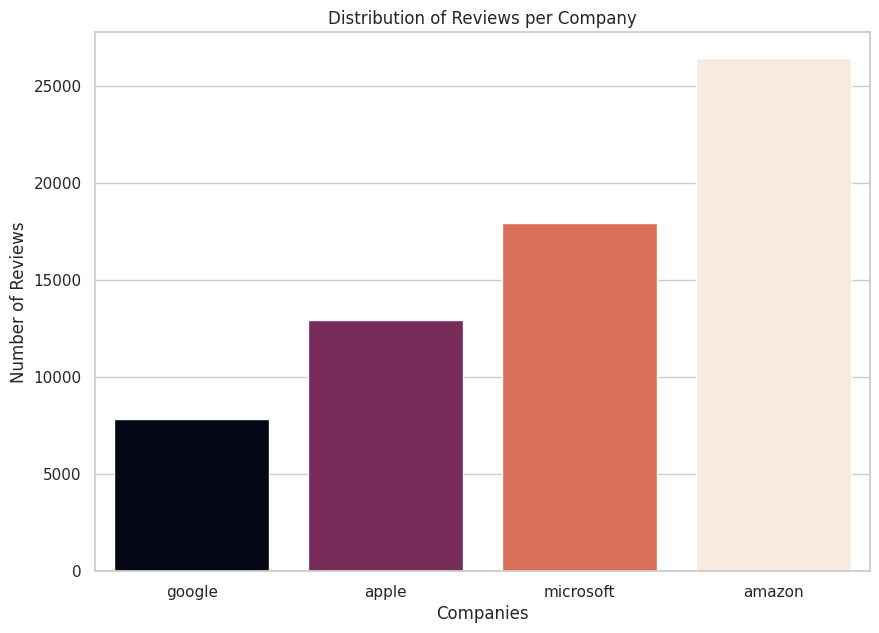

In [25]:
reviews_count = df['company'].value_counts().sort_values(ascending=True)
comp_labels = reviews_count.index.tolist()
comp_index = np.arange(len(comp_labels))
sns.set(style="whitegrid")

plt.figure(figsize=(10,7))
#sns.barplot(x=comp_index, y=reviews_count, palette="rocket") ~ will be deprecated
sns.barplot(x=comp_index, y=reviews_count, palette="rocket", hue=comp_index, dodge=False, legend=False)
plt.xticks(comp_index, comp_labels)
plt.xlabel('Companies')
plt.ylabel('Number of Reviews')
_ = plt.title('Distribution of Reviews per Company')
#plt.savefig("Plots/distribution_reviews.png", dpi=900)

### B. Reviews per Year

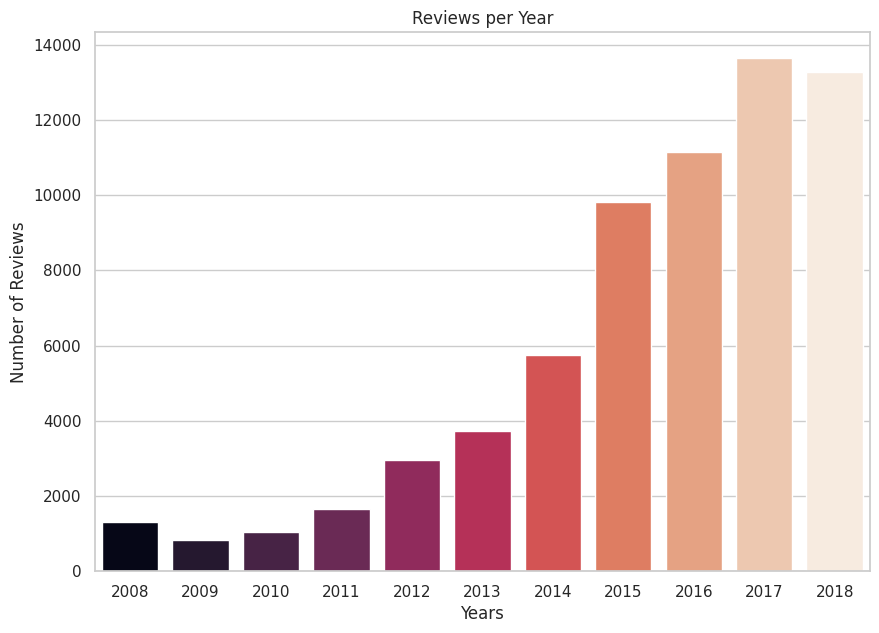

In [26]:
years_count = df['year'].value_counts().sort_index(ascending=True)
years_labels = years_count.index.tolist()
years_index = np.arange(len(years_labels))

plt.figure(figsize=(10,7))
_ = sns.barplot(x=years_index, y=years_count, hue = years_index, palette = 'rocket', dodge=False, legend=False)
_ = plt.xticks(years_index, years_labels)
_ = plt.xlabel("Years")
_ = plt.ylabel("Number of Reviews")
_ = plt.title("Reviews per Year")

### C. Reviews per year per company

Observations: Most of the reviews are from 2015-2018. There are reviews from as far back as 2008

* Google: Most reviews from past 4 years
* Apple: Most reviews from past 4-5 years
* Microsoft: Most reviews from past 4-6 years
* Amazon: Most reviews from past 2-4 years

Based on the observations above, we will only consider reviews from the 4 years (2015-2018) since they might be the most relevant in figuring out what makes each company good or bad.

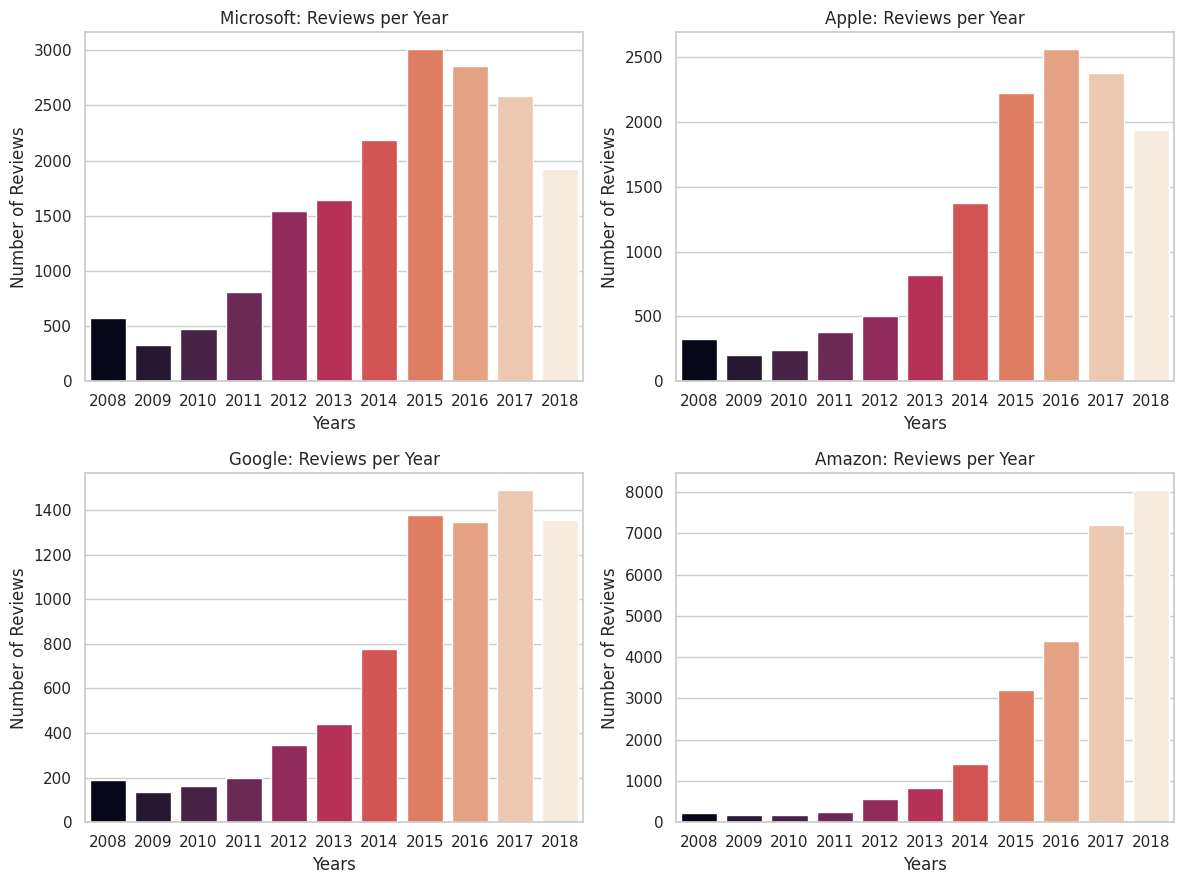

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
companies = [['microsoft', 'apple'], ['google', 'amazon']]

for i in range(2):
    for j in range(2):
        company = companies[i][j]
        years_count = df[df['company'] == company]['year'].value_counts().sort_index(ascending=True)
        years_labels = years_count.index.tolist()
        years_index = np.arange(len(years_labels))

        #g = sns.barplot(x=years_labels, y=years_count, hue=years_index, ax=axs[i][j], palette='rocket', dodge=False, legend = False)
        # or
        g = sns.barplot(x=years_index, y=years_count, hue=years_index, ax=axs[i][j], palette='rocket', dodge=False, legend = False)
        axs[i][j].set_xticks(years_index)
        axs[i][j].set_xticklabels(years_labels)
        _ = axs[i][j].set_xlabel("Years")
        _ = axs[i][j].set_ylabel("Number of Reviews")
        _ = axs[i][j].set_title("{}: Reviews per Year".format(company.title()))

fig.tight_layout()
plt.show()

In [28]:
df = df[df["year"].isin([2018, 2017, 2016, 2015])]
df['year'].unique()

array([2018, 2015, 2017, 2016])

# E. Rating over time
How has the average rating of each company changed over the past two years

In [29]:
df.groupby(['year', 'company'])['overall-ratings'].mean().unstack()

company,amazon,apple,google,microsoft
year,,,,
2015,3.360625,4.028327,4.357039,3.843906
2016,3.519608,3.990632,4.432493,3.962833
2017,3.711469,3.994100,4.412081,4.032895
2018,3.727092,3.975245,4.383309,4.061490


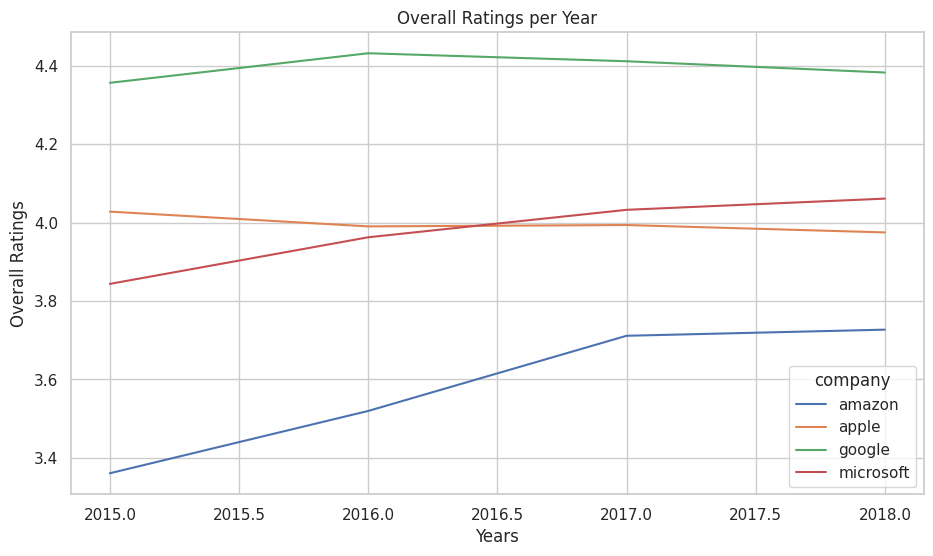

In [30]:
fig, ax = plt.subplots(figsize=(11,6))
df.groupby(['year', 'company'])['overall-ratings'].mean().unstack().plot(ax=ax)
_ = plt.xlabel("Years")
_ = plt.ylabel("Overall Ratings")
_ = plt.title("Overall Ratings per Year")
#plt.savefig("Plots/rating_year_company.png", dpi=900)


### F. Distribution of Reviews by type of employee (Current vs Former)


Obeservations: Most of the reviews seem to come from current employees. Although this is good since it probably means that the reviews are relevant, it also begs the question of how much bias there is.

In [31]:
current_employee_count = df['job-title'].str.split('-', expand=True)[0].value_counts().sort_values(ascending=True)

In [32]:
current_employee_count.index.tolist()

['Former Employee ', 'Current Employee ']

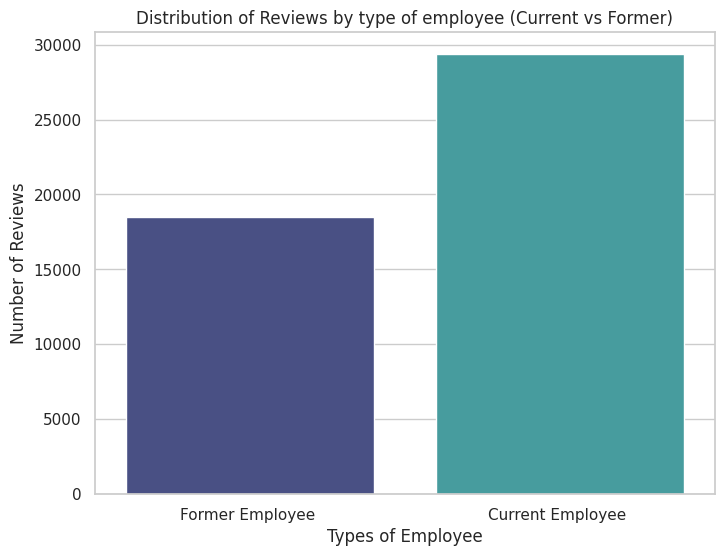

In [33]:
current_employee_count = df['job-title'].str.split('-', expand=True)[0].value_counts().sort_values(ascending=True)
employee_labels = current_employee_count.index.tolist()
employee_index = np.arange(len(employee_labels))


plt.figure(figsize=(8,6))
_ = sns.barplot(x = employee_index, y = current_employee_count,hue=employee_index, palette='mako', dodge=False, legend=False)
_ = plt.xticks(employee_index, employee_labels)

_ = plt.xlabel('Types of Employee')
_ = plt.ylabel('Number of Reviews')
_ = plt.title('Distribution of Reviews by type of employee (Current vs Former)')
#plt.savefig("Plots/reviews_employee_type.png", dpi=900)

###G. Average ratings for different feature (by company)

In [34]:
df.columns

Index(['Unnamed: 0', 'company', 'location', 'dates', 'job-title', 'summary',
       'pros', 'cons', 'overall-ratings', 'work-balance-stars',
       'culture-values-stars', 'carrer-opportunities-stars',
       'comp-benefit-stars', 'senior-mangemnet-stars', 'helpful-count',
       'year'],
      dtype='object')

In [35]:
ratings_comp = df[["company", "work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]]
ratings_comp.set_index(["company"], inplace=True)

In [36]:
ratings_comp

,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars
company,,,,,
google,4.0,5.0,5.0,4.0,5.0
google,2.0,5.0,5.0,4.0,5.0
google,5.0,5.0,5.0,5.0,5.0
google,4.0,4.0,4.0,5.0,4.0
google,5.0,4.0,4.0,5.0,4.0
...,...,...,...,...,...
microsoft,3.0,3.0,4.0,4.0,2.0
microsoft,3.0,3.0,3.0,1.0,3.0
microsoft,3.0,4.0,5.0,4.0,4.0


In [37]:
ratings_comp.isnull().sum()

work-balance-stars            0
culture-values-stars          0
carrer-opportunities-stars    0
comp-benefit-stars            0
senior-mangemnet-stars        0
dtype: int64

In [38]:
ratings_comp=ratings_comp[~(ratings_comp[["work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]] == "none").any(axis=1)]

In [39]:
ratings_comp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40911 entries, google to microsoft
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   work-balance-stars          40911 non-null  object
 1   culture-values-stars        40911 non-null  object
 2   carrer-opportunities-stars  40911 non-null  object
 3   comp-benefit-stars          40911 non-null  object
 4   senior-mangemnet-stars      40911 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


In [40]:
ratings_comp = ratings_comp[~(ratings_comp[["work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]] == "none").any(axis=1)]
ratings_comp[["work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]] = ratings_comp[["work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]].apply(pd.to_numeric)
group = ratings_comp.groupby("company")[["work-balance-stars", "culture-values-stars", "carrer-opportunities-stars", "comp-benefit-stars", "senior-mangemnet-stars"]].mean()
group.columns = ["Work Balance", "Culture Values", "Career Opportunities", "Company Benefits", "Senior Management"]

In [41]:
group = group.transpose()
group

company,amazon,apple,google,microsoft
Work Balance,3.061221,3.354623,4.026761,3.647832
Culture Values,3.558759,4.105820,4.352470,3.781622
Career Opportunities,3.644601,3.462711,4.081885,3.754100
Company Benefits,3.730545,4.113001,4.449680,4.055493
Senior Management,3.196000,3.467120,3.887694,3.348686



**Observations**: Overall, Google holds the best ratings for Work Balance, Culture Values, Career Opportunities, Company Benefits, and Senior Management.

* Apple is second in Senior Management, Company Benefits, and Culture Values.
* Microsoft is second in Work Balance and Career Opportunities

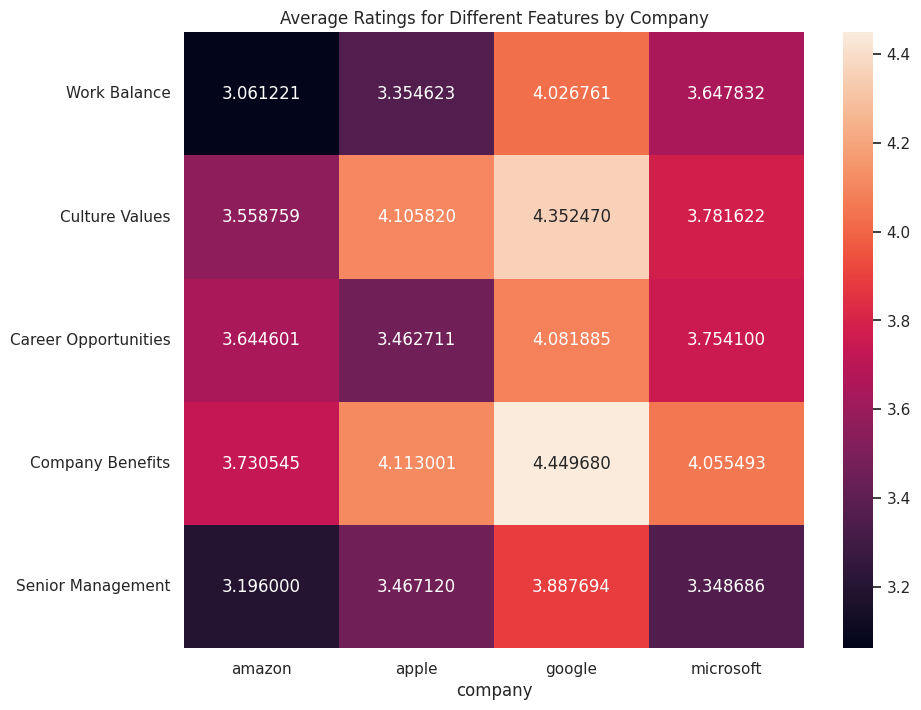

In [48]:
plt.figure(figsize=(10,8))
_ = sns.heatmap(group, annot=True, fmt="f")
_ = plt.title("Average Ratings for Different Features by Company")

In [60]:
work_ratings = df[['company', 'overall-ratings']]
work_ratings = work_ratings[~(work_ratings[['overall-ratings']] == "none").any(axis=1)]
work_ratings['overall-ratings'] = work_ratings['overall-ratings'].apply(pd.to_numeric)
work_ratings

,company,overall-ratings
0,google,5.0
3,google,5.0
4,google,5.0
5,google,5.0
6,google,5.0
...,...,...
65559,microsoft,3.0
65560,microsoft,3.0
65561,microsoft,4.0
65562,microsoft,4.0


In [72]:
group2 = work_ratings.groupby(work_ratings["company"])['overall-ratings'].mean().reset_index()
group2

,company,overall-ratings
0,amazon,3.630987
1,apple,3.997472
2,google,4.396409
3,microsoft,3.964017


In [65]:
group = work_ratings.groupby(work_ratings["company"].str.title())['overall-ratings'].mean().reset_index()

In [74]:
group

,company,overall-ratings
0,Amazon,3.630987
1,Apple,3.997472
2,Google,4.396409
3,Microsoft,3.964017


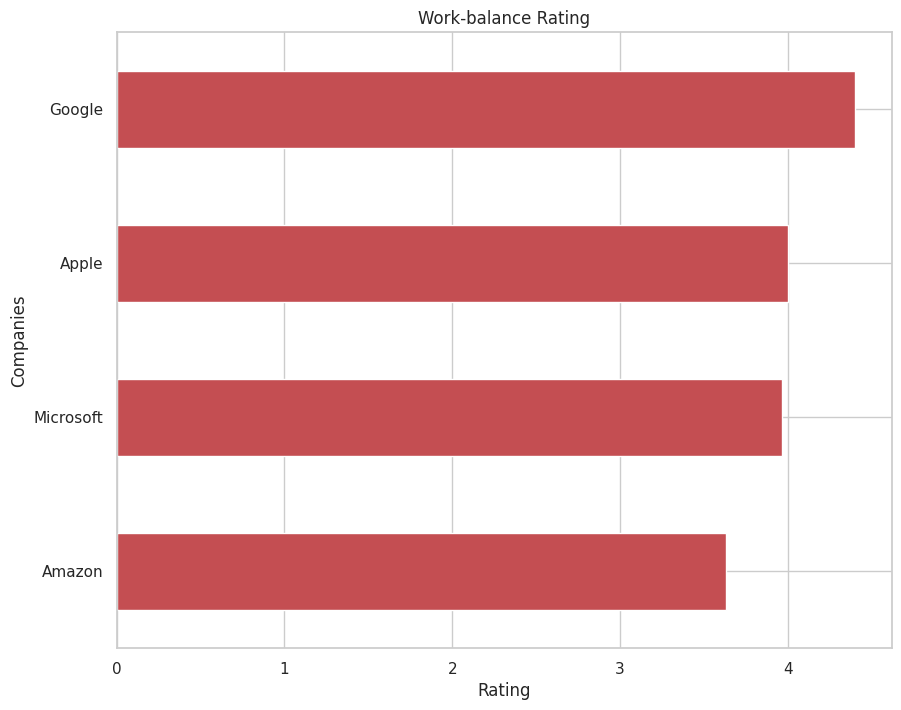

In [76]:
group.sort_values(['overall-ratings'],inplace=True)
group.set_index('company').plot.barh(legend=False, figsize=(10,8), color="r")
plt.title('{} Rating'.format("Work-balance"))
plt.xlabel('Rating')
_ = plt.ylabel('Companies')

In [78]:
def rating_per_company(rating_type, title, color):
    work_ratings = df[['company', rating_type]]
    work_ratings = work_ratings[~(work_ratings[[rating_type]] == "none").any(axis=1)]
    work_ratings[rating_type] = work_ratings[rating_type].apply(pd.to_numeric)
    group = work_ratings.groupby(work_ratings["company"].str.title())[rating_type].mean().reset_index()
    group.sort_values([rating_type],inplace=True)
    group.set_index('company').plot.barh(legend=False, figsize=(10,8), color=color)
    plt.title('{} Rating'.format(title))
    plt.xlabel('Rating')
    _ = plt.ylabel('Companies')
    #plt.savefig("Plots/{}_rating_company.png".format(title.lower().replace(" ", "_")), dpi=900)

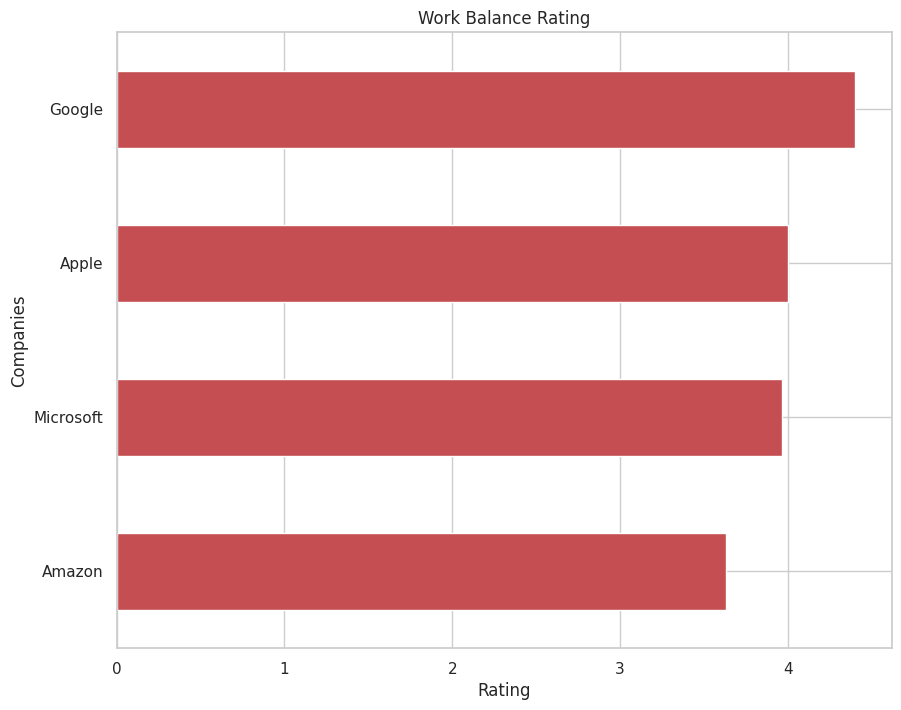

In [59]:
rating_per_company('overall-ratings', "Work Balance", "r")

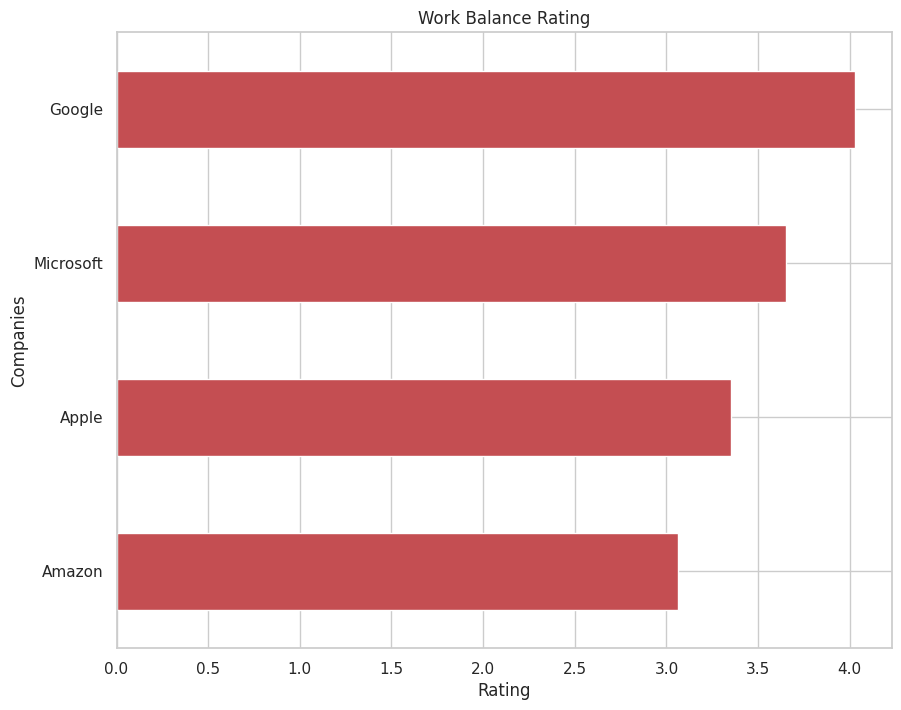

In [77]:
rating_per_company('work-balance-stars', "Work Balance", "r")

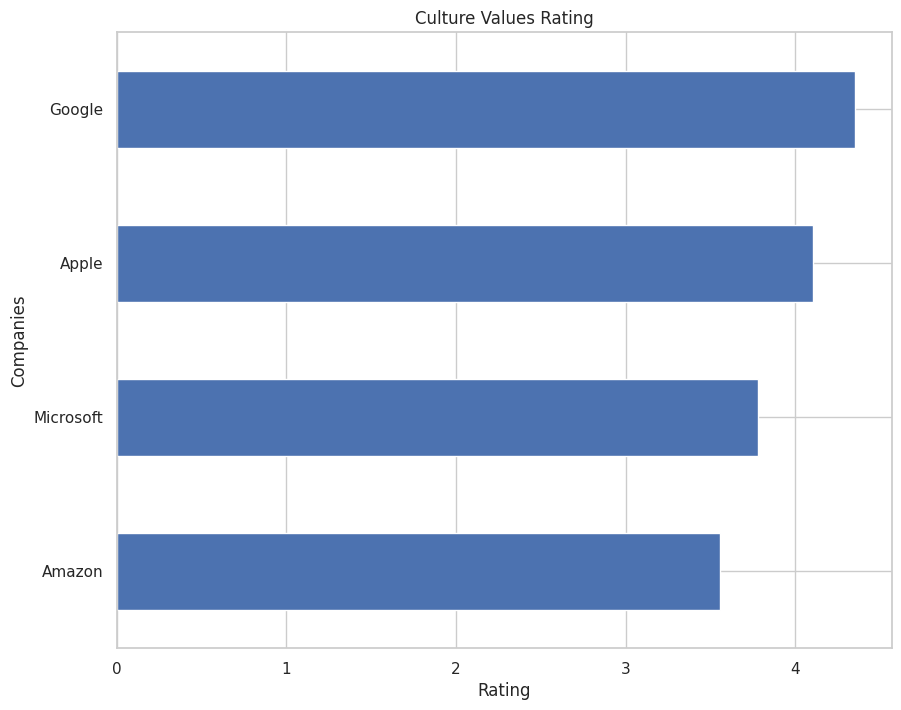

In [81]:
rating_per_company("culture-values-stars", "Culture Values", "b")

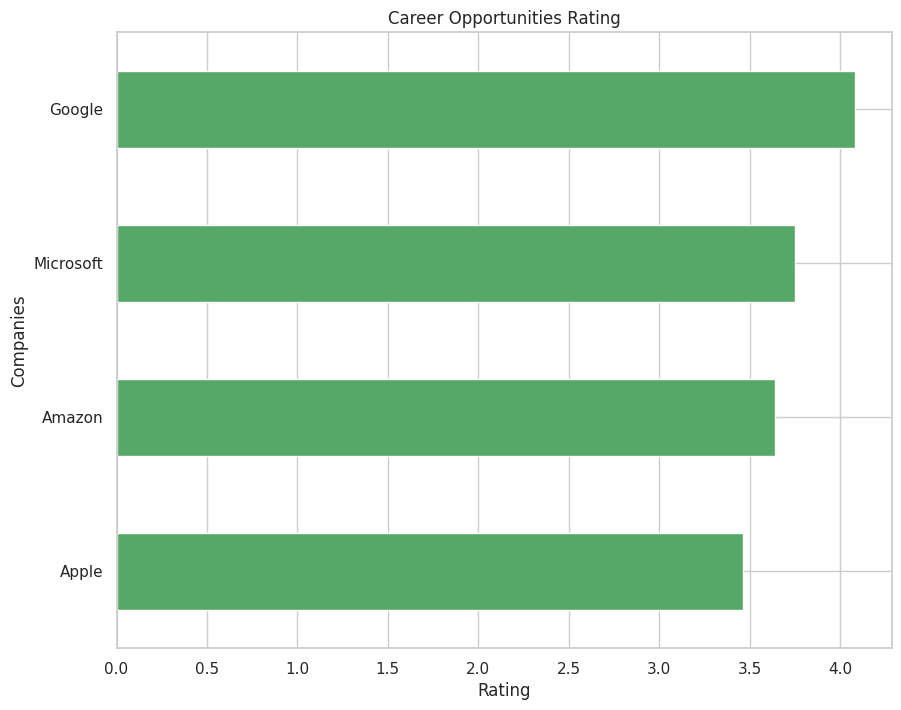

In [82]:
rating_per_company("carrer-opportunities-stars", "Career Opportunities", "g")

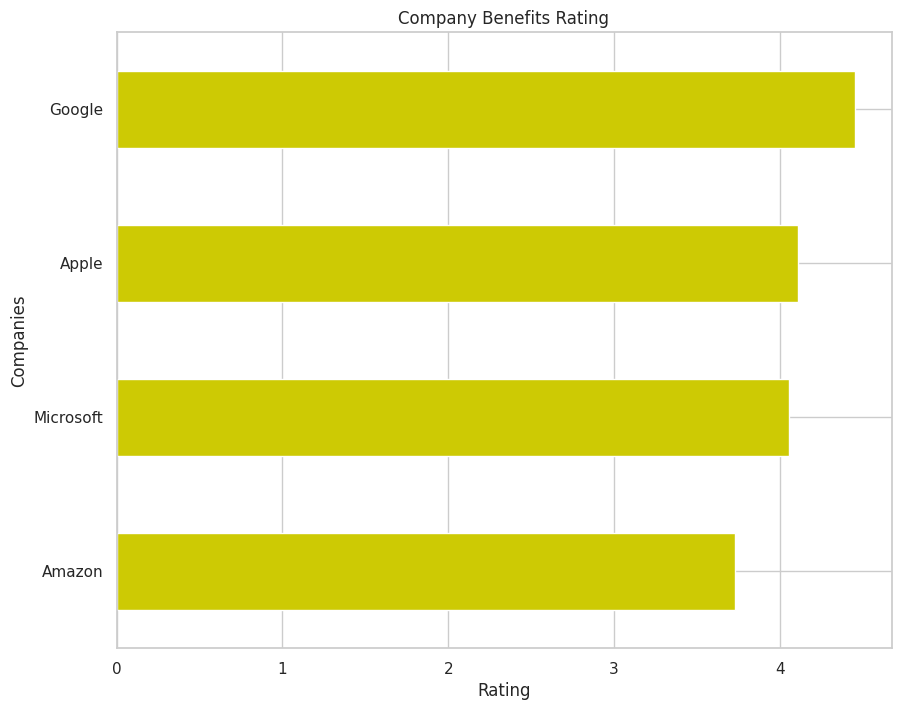

In [83]:
rating_per_company("comp-benefit-stars", "Company Benefits", "#cdca04")

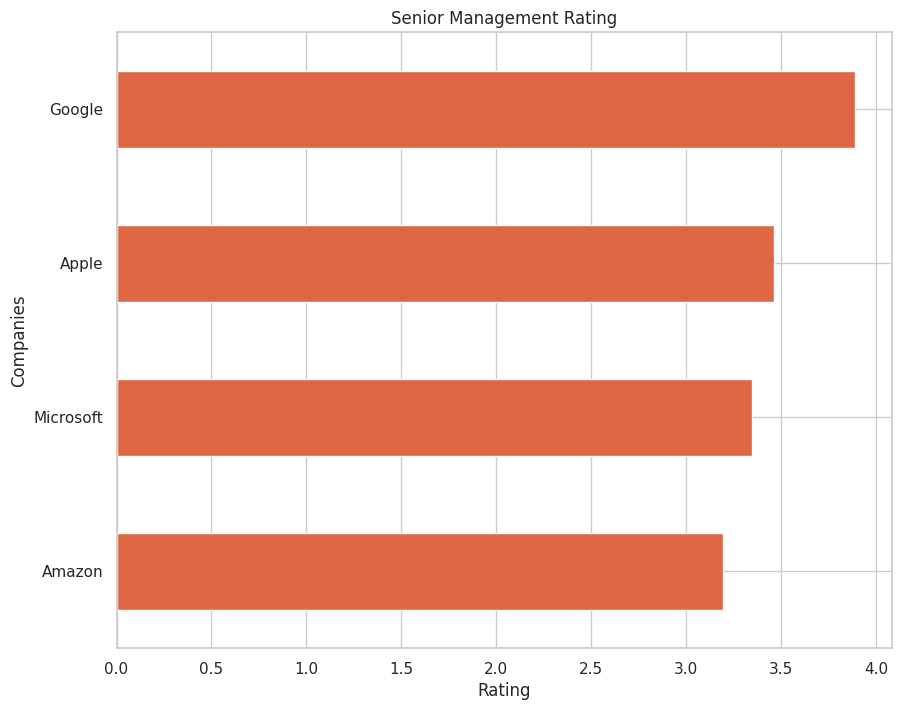

In [84]:
rating_per_company("senior-mangemnet-stars", "Senior Management", "#e06743")

##H. Who is reviewing
Identify, who is reviewing, current or former employee, what title?

In [94]:
current_employee_count = df.loc[df['company'] == 'amazon']['job-title'].str.split('-', expand=True)[0].value_counts().sort_values(ascending=True)

In [95]:
employee_labels = current_employee_count.index.tolist()
employee_index = np.arange(len(employee_labels))

In [96]:
employee_labels

['Former Employee ', 'Current Employee ']

In [97]:
employee_index

array([0, 1])

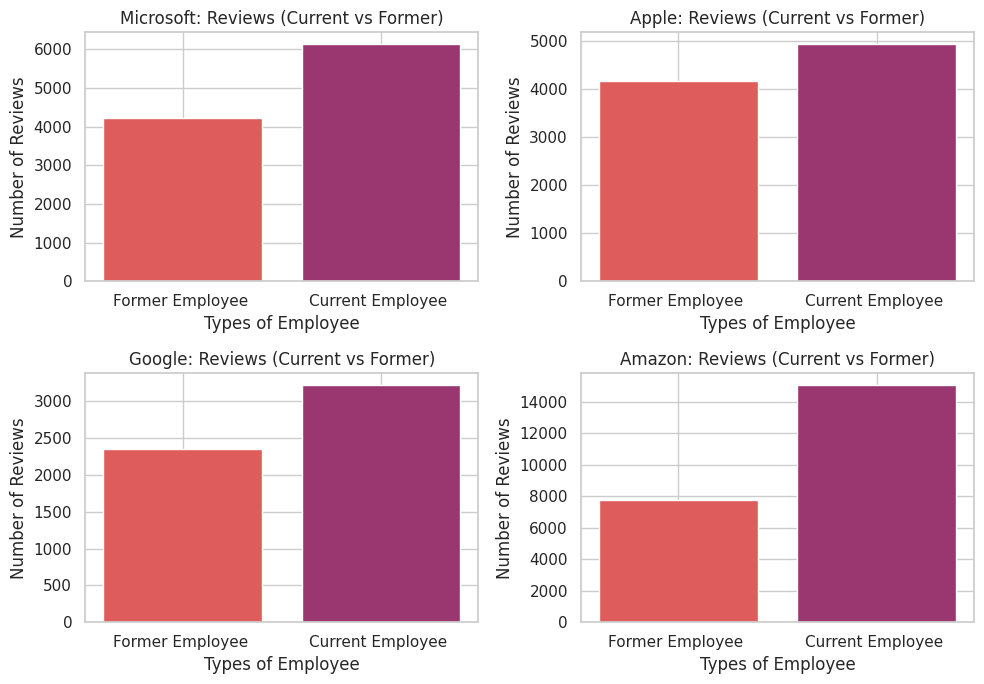

In [108]:
fig, axs = plt.subplots(2,2, figsize=(10,7), facecolor='w', edgecolor='k')
companies = ['microsoft', 'apple', 'google', 'amazon']
axs = axs.ravel()


for i, company in enumerate(companies):
    current_employee_count = df.loc[df['company'] == company]['job-title'].str.split('-', expand=True)[0].value_counts().sort_values(ascending=True)
    employee_labels = current_employee_count.index.tolist()
    employee_index = np.arange(len(employee_labels))

    bars = axs[i].bar(employee_index, current_employee_count, tick_label=employee_labels, color=sns.color_palette('flare', 2))
    #bars[0].set_color('gray')
    #bars[1].set_color('b')
    _ = axs[i].set_xlabel('Types of Employee')
    _ = axs[i].set_ylabel('Number of Reviews')
    _ = axs[i].set_title('{}: Reviews (Current vs Former)'.format(company.title()))

fig.tight_layout()
#fig.savefig("Plots/reviews_employee_type_company.png", dpi=900)

Obeservations: Most of the job titles is anonymous. Based on this, it many not be worth it to summarize the data based on the job title.

In [109]:
df['job-title'].str.split(' - ', expand=True)[1].value_counts().head(5)

1
Anonymous Employee               21910
Software Engineer                  930
Specialist                         648
Software Development Engineer      618
Warehouse Associate                585
Name: count, dtype: int64

## I. Average Rating of Current vs Former Employee (per Company)
Let's see what the average rating of current and former employees per company

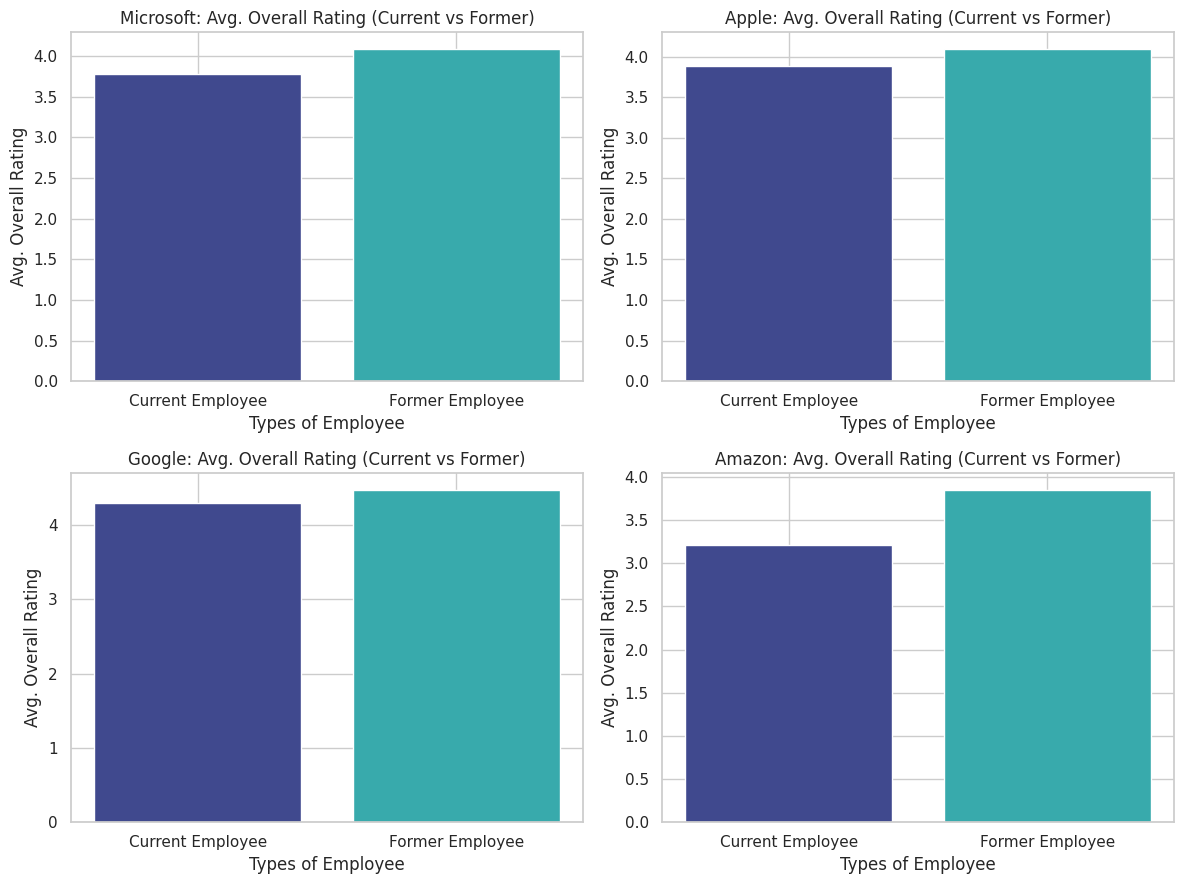

In [110]:
fig, axs = plt.subplots(2,2, figsize=(12, 9), facecolor='w', edgecolor='k')
companies = ['microsoft', 'apple', 'google', 'amazon']
axs = axs.ravel()

for i, company in enumerate(companies):

        job_rating = df[df['company'] == company][['job-title', 'overall-ratings']]
        job_rating['job-title'] = job_rating['job-title'].str.split(' - ', expand=True)[0]
        job_rating_count = job_rating.groupby('job-title')['overall-ratings'].mean().sort_values(ascending=True)

        bars = axs[i].bar([0,1], job_rating_count, tick_label = ['Current Employee', 'Former Employee'],color=sns.color_palette('mako', 2))
        # bars[0].set_color('gray')
        # bars[1].set_color('b')
        _ = axs[i].set_title('{}: Avg. Overall Rating (Current vs Former)'.format(company.title()))
        _ = axs[i].set_xlabel("Types of Employee")
        _ = axs[i].set_ylabel("Avg. Overall Rating")

fig.tight_layout()
#fig.savefig("Plots/rating_employee_type_company.png", dpi=900)

### What are Pros and Cons about
Identify trend or top keywords in the pros and cons comments

In [113]:
pd.set_option('display.max_colwidth', 1)
df[['pros']].head(5)

pros
0  People are smart and friendly                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [114]:
df['pros'].str.split().str.len()

0        5   
3        283 
4        1416
5        29  
6        7   
        ..   
65559    13  
65560    47  
65561    6   
65562    9   
65564    5   
Name: pros, Length: 47876, dtype: int64

In [115]:
df['cons'].str.split().str.len()

0        5  
3        497
4        815
5        14 
6        5  
        ..  
65559    22 
65560    135
65561    6  
65562    12 
65564    5  
Name: cons, Length: 47876, dtype: int64

In [116]:
pros_count = df['pros'].str.split().str.len()
cons_count = df['cons'].str.split().str.len()
#summary_count = df['summary'].str.split().str.len()

Observations: We can that the word count between comments varies by a lot. We have reviews with just a few words and others that are multiple paragraphs. 50% of comments (pros and cons) are between 12-15 words long.

In [117]:
pros_count.describe()

count    47876.000000
mean     18.542192   
std      26.214323   
min      2.000000    
25%      7.000000    
50%      11.000000   
75%      22.000000   
max      1416.000000 
Name: pros, dtype: float64

In [118]:
cons_count.describe()

count    47876.000000
mean     26.863000   
std      53.772301   
min      1.000000    
25%      7.000000    
50%      13.000000   
75%      27.000000   
max      1940.000000 
Name: cons, dtype: float64

### Clean and Transform Data

In [120]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [122]:
stop_words = set(stopwords.words("english"))
stop_words = stop_words.union(df["company"].unique()) # Include Company names
print(stop_words)

{'has', "couldn't", 'are', 'because', 'o', 've', 'wasn', 'which', 'or', 'ours', "you're", 'of', 'into', 'but', 'we', 'they', 'i', 'such', 'above', "she's", 'having', 'ma', 'its', 'itself', 'most', 'google', 'been', 'not', 'until', 'further', 'down', 'she', 'these', "hasn't", "isn't", 'microsoft', 'haven', 'them', "weren't", 'that', 'too', 'doesn', 'few', 'then', 'off', 'm', 'some', 'shouldn', 'be', 'amazon', 'himself', 'with', 'once', 'the', 'between', 'had', "mustn't", 'any', 're', 'as', 'for', 'isn', 'mightn', 'does', "won't", "you'll", "that'll", 'so', 'nor', 'an', 'to', 'hadn', 'herself', 'should', 'his', 'am', "shouldn't", 'before', 'hasn', 'own', 'whom', 'my', 't', 'other', 'needn', "mightn't", 'apple', 'me', 'll', "needn't", 'weren', 'ourselves', 'being', 'at', 'below', 'your', 'there', "wasn't", "didn't", "you'd", 'on', 'couldn', 'aren', 'after', 'won', "you've", 'while', 'him', 'about', 'their', 'in', 'can', 'themselves', 'same', 'our', 'why', 'all', 'up', 'under', 'wouldn', '

In [123]:
def top_words(company, review_type, stop_words, top=20):

    corpus = df[df['company'] == company][review_type].str.lower()

    # Remove punctuations
    corpus = corpus.str.replace("[^a-zA-Z]", " ")

    # Convert to list from string
    corpus = corpus.str.split()

    # Remove stop words
    corpus = corpus.apply(lambda x: [word for word in x if word not in stop_words])


    # Lemmatisation
    lem = WordNetLemmatizer()

    def lemmatize_text(text):
        return [lem.lemmatize(word) for word in text]

    corpus = corpus.apply(lemmatize_text)

    corpus = corpus.apply(pd.Series).stack()

    return set(corpus.value_counts()[:top].index.tolist())

In [124]:
google_pros = top_words("google", "pros", stop_words)
micro_pros = top_words("microsoft", "pros", stop_words)
apple_pros = top_words("apple", "pros", stop_words)
amazon_pros = top_words("amazon", "pros", stop_words)

company_common_pros = set.intersection(google_pros, micro_pros, apple_pros, amazon_pros)
company_common_pros

{'-',
 'benefit',
 'company',
 'environment',
 'good',
 'great',
 'lot',
 'people',
 'work',
 'working'}

In [125]:
google_cons = top_words("google", "cons", stop_words)
micro_cons = top_words("microsoft", "cons", stop_words)
apple_cons = top_words("apple", "cons", stop_words)
amazon_cons = top_words("amazon", "cons", stop_words)

company_common_cons = set.intersection(google_cons, micro_cons, apple_cons, amazon_cons)
company_common_cons

{'-',
 'company',
 'get',
 'hard',
 'like',
 'lot',
 'management',
 'much',
 'people',
 'time',
 'work'}

In [126]:
pd.options.display.max_rows = 4000
cons_common = pd.Series(' '.join(df['cons'].str.lower()).split()).value_counts()[:70]
print(cons_common)

to            43006
the           40329
and           31526
a             27092
of            24277
you           23134
is            22275
in            15984
are           14621
for           14306
not           13961
work          12606
be            12216
i             9968 
on            9928 
that          9479 
it            8992 
they          8901 
with          8569 
no            8506 
can           8392 
have          8379 
your          8343 
at            7610 
-             6874 
as            6782 
very          6760 
if            6611 
get           6590 
but           6275 
or            5458 
people        5342 
there         5293 
management    5072 
will          4934 
so            4743 
company       4720 
this          4596 
time          4551 
too           4222 
from          4217 
was           4148 
some          3945 
do            3763 
more          3736 
like          3693 
hours         3610 
much          3599 
all           3572 
their         3441 


In [127]:
cons_except = {"hours", "hard", "time", "life"}
cons_stop = set(cons_common.index.tolist())
cons_stop = cons_stop - set(cons_except)
cons_stop = cons_stop.union(company_common_cons)
pros_common = pd.Series(' '.join(df['pros'].str.lower()).split()).value_counts()[:70]
print(pros_common)

and              33737
to               29449
the              25593
work             17717
great            17626
of               17303
a                17044
good             14674
you              14573
is               13826
for              10281
are              9585 
in               9309 
with             8442 
people           7225 
-                6926 
i                6436 
benefits         6292 
company          6207 
on               5894 
very             5615 
your             4767 
that             4580 
pay              4181 
working          4155 
have             4040 
it               3984 
at               3908 
as               3721 
get              3680 
can              3562 
if               3475 
be               3418 
environment      3368 
they             3311 
place            3279 
benefits,        3130 
lot              3117 
from             3050 
opportunities    3016 
smart            3014 
lots             2799 
learn            2777 
culture    

In [128]:
pros_except = {"culture", "learn", "smart", "opportunities", "environment", "amazing", "team", "flexible", "opportunity"}
pros_stop = set(pros_common.index.tolist())
pros_stop = pros_stop - set(pros_except)
pros_stop = pros_stop.union(company_common_pros)

In [129]:
def create_cloud(company, review_type, new_stop):
    # Convert to lowercase
    corpus = df[df['company'] == company][review_type].str.lower()

    # Remove punctuations
    corpus = corpus.str.replace("[^a-zA-Z]", " ")

    # Convert to list from string
    corpus = corpus.str.split()

    # Remove stop words
    new_stop = stop_words.union(new_stop)
    corpus = corpus.apply(lambda x: [word for word in x if word not in new_stop])


    # Lemmatisation
    lem = WordNetLemmatizer()

    def lemmatize_text(text):
        return [lem.lemmatize(word) for word in text]

    corpus = corpus.apply(lemmatize_text)

    corpus = corpus.str.join(" ")

    # Remove Tags
    #text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

    # Remove special characters and digits
    #corpus = corpus.str.replace("(\\d|\\W)+", " ")

    return WordCloud(width=3000, height = 2000, max_words = 50, random_state = 42, background_color = "white", stopwords = new_stop).generate(" ".join(corpus))

Note: Aside from stop words, the following words were common (and very frequent) among all 4 companies, but were not included in the wordclouds: 'benefit','company', 'culture', 'environment', 'good', 'great', 'lot', 'opportunity', 'people','work', 'working'

These words are all important in trying to figure out what makes these companies good, but I decided to leave them out in order to make room for other frequent keywords that may be more insighful about each company.

**Observations:**

* Google: Team, Hard word, , the project, politics and life balance
* Amazon: Lack of life-balance, the hours, the culture.
* Apple: The life-balance, retail, customers, the pay
* Microsoft: Politics, the work-life balance, team, the hard work, the culture

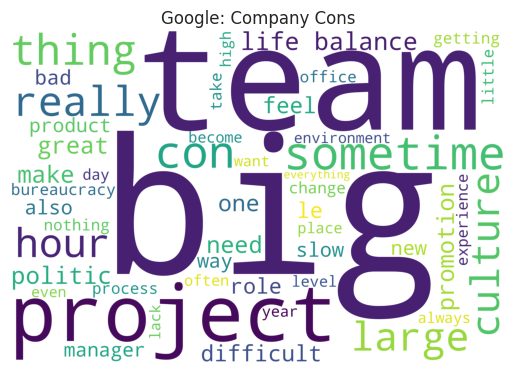

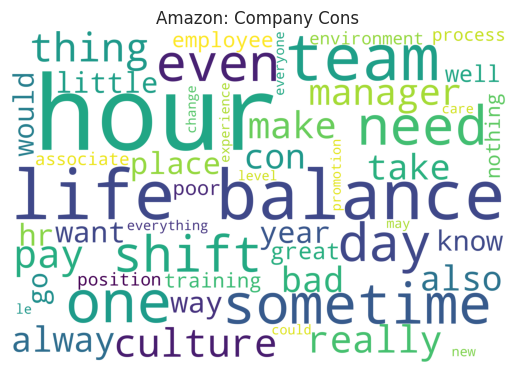

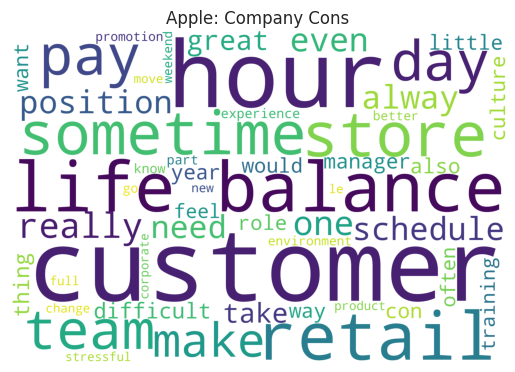

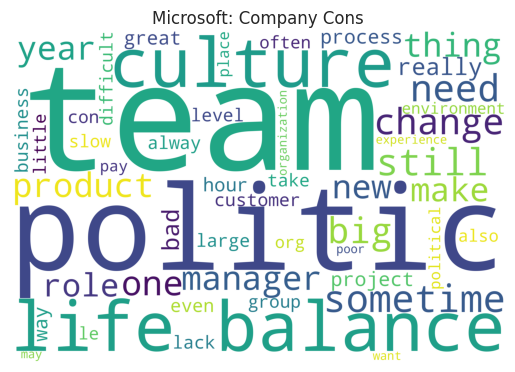

In [130]:
for i, company in enumerate(df["company"].unique()):
    #ax = fig.add_subplot(1,4,i+1)
    word_cloud = create_cloud(company, "cons", cons_stop)

    fig = plt.figure()
    plt.imshow(word_cloud)
    plt.title("{}: Company Cons".format(company.title()))
    plt.axis('off')

Observations:

* Google: Perks, smart people, Free Food, salary.
* Amazon: Learn, the team
* Apple: Discount, the products, the team, fun, training
* Microsoft: Smart people, product, the salary, technology, the team.

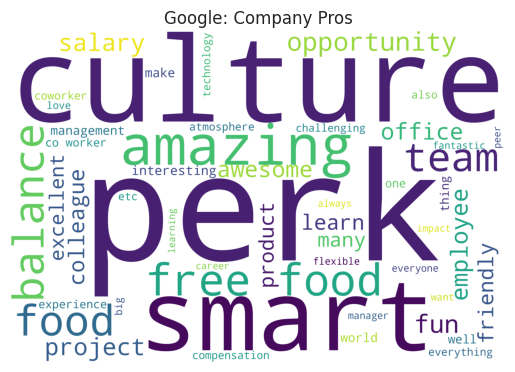

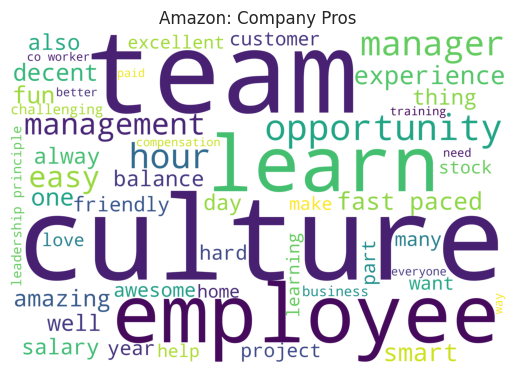

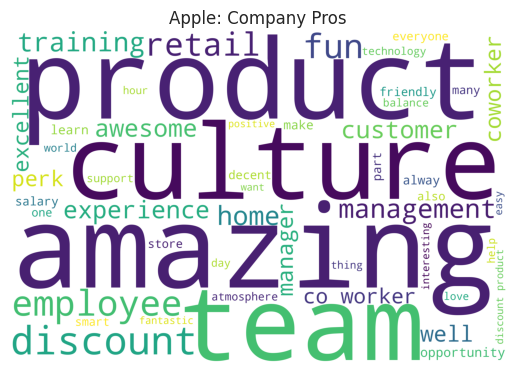

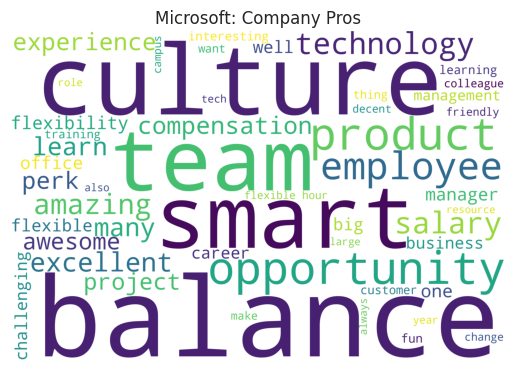

In [131]:
for i, company in enumerate(df["company"].unique()):
    #ax = fig.add_subplot(1,4,i+1)
    word_cloud = create_cloud(company, "pros", pros_stop)

    fig = plt.figure()
    plt.imshow(word_cloud)
    plt.title("{}: Company Pros".format(company.title()))
    plt.axis('off')
    #fig.savefig("Plots/{}_pros_wordcloud.png".format(company), dpi=900)